<a href="https://colab.research.google.com/github/ouhenio/stylegan3-projector/blob/add-w-plus/StyleGAN3%2BInversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown #**Setup libraries and functions** 🏗️🛠️

!pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install --upgrade https://download.pytorch.org/whl/nightly/cu111/torch-1.11.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl https://download.pytorch.org/whl/nightly/cu111/torchvision-0.12.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl
!git clone https://github.com/NVlabs/stylegan3
!pip install einops ninja
!pip install wget 

import sys
sys.path.append('./stylegan3')

import io
import os, time
import pickle
import shutil
import numpy as np
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import copy
import imageio
import unicodedata
import re
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files
from time import perf_counter
from stylegan3.dnnlib.util import open_url
import wget


device = torch.device('cuda:0')

# Load VGG16 feature detector.
url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
with open_url(url) as f:
    vgg16 = torch.jit.load(f).eval().to(device)
print('Using device:', device, file=sys.stderr)

def fetch_model(url_or_path):
    if "drive.google" in url_or_path:
      if "18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj" in url_or_path: 
        basename = "wikiart-1024-stylegan3-t-17.2Mimg.pkl"
      elif "14UGDDOusZ9TMb-pOrF0PAjMGVWLSAii1" in url_or_path:
        basename = "lhq-256-stylegan3-t-25Mimg.pkl"
    else:
        basename = os.path.basename(url_or_path)
    if os.path.exists(basename):
        return basename
    else:
        if "drive.google" not in url_or_path:
          !wget -c '{url_or_path}'
        else:
          path_id = url_or_path.split("id=")[-1]
          !gdown --id '{path_id}'
        return basename

def download_img(img_url):
    try:
        return wget.download(img_url,out="input.jpg")
    except:
        return

# Projector

def project(
    G,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = -1,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    verbose                    = False,
    device: torch.device
):

    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    def logprint(*args):
        if verbose:
            print(*args)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore

    # Compute w stats.
    if w_avg_samples > 0:
      logprint(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
      z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    else:
      seed = np.random.randint(0, 2**32 - 1)
      z_samples = np.random.RandomState(seed).randn(1, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth images from opt_w.
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        synth_images = G.synthesis(ws, noise_mode='const')

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (target_features - synth_features).square().sum()

        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = dist + reg_loss * regularize_noise_weight

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        logprint(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')

        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    return w_out.repeat([1, G.mapping.num_ws, 1])

def get_perceptual_loss(synth_image, target_features):
    # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
    synth_image = (synth_image + 1) * (255/2)
    if synth_image.shape[2] > 256:
        synth_image = F.interpolate(synth_image, size=(256, 256), mode='area')

    # Features for synth images.
    synth_features = vgg16(synth_image, resize_images=False, return_lpips=True)
    return (target_features - synth_features).square().sum()

def get_target_features(target):
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    return vgg16(target_images, resize_images=False, return_lpips=True)

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.3 MB/s eta 0:15:20tcmalloc: large alloc 1147494400 bytes == 0x39c3e000 @  0x7fc8e1707615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████▌               | 1055.7 MB 1.3 MB/s eta 0:12:33tcmalloc: large alloc 1434370048 bytes == 0x7e294000 @  0x7fc8e1707615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████           | 1336.2 MB 1.3 MB/s eta 0:09:22tcmalloc: large alloc 1792966656 bytes =

Using device: cuda:0


In [2]:
#@markdown #**Model selection** 🎭


#@markdown There are 4 pre-trained options to play with:
#@markdown - FFHQ: Trained with human faces.
#@markdown - MetFaces: Trained with paintings/portraits of human faces.
#@markdown - AFHQv2: Trained with animal faces.
#@markdown - Cosplay: Trained by [l4rz](https://twitter.com/l4rz) with cosplayer's faces.
#@markdown - Wikiart: Trained by [Justin Pinkney](https://www.justinpinkney.com/) with the Wikiart 1024 dataset.
#@markdown - Landscapes: Trained by [Justin Pinkney](https://www.justinpinkney.com/) with the LHQ dataset.


#@markdown **Run this cell again if you change the model**.

#@markdown ---

base_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/"

Model = 'FFHQ' #@param ["FFHQ", "MetFaces", "AFHQv2", "cosplay", "Wikiart", "Landscapes"]

#@markdown ---

model_name = {
    "FFHQ": base_url + "stylegan3-t-ffhqu-1024x1024.pkl",
    "MetFaces": base_url + "stylegan3-r-metfacesu-1024x1024.pkl",
    "AFHQv2": base_url + "stylegan3-t-afhqv2-512x512.pkl",
    "cosplay": "https://l4rz.net/cosplayface-snapshot-stylegan3t-008000.pkl",
    "Wikiart": "https://archive.org/download/wikiart-1024-stylegan3-t-17.2Mimg/wikiart-1024-stylegan3-t-17.2Mimg.pkl",
    "Landscapes": "https://archive.org/download/lhq-256-stylegan3-t-25Mimg/lhq-256-stylegan3-t-25Mimg.pkl"
}

network_url = model_name[Model]

with open(fetch_model(network_url), 'rb') as fp:
  G = pickle.load(fp)['G_ema'].to(device)

zs = torch.randn([10000, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0)

--2022-05-17 15:38:34--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 54.214.150.211, 35.160.122.182
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|54.214.150.211|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://prod-model-registry-ngc-bucket.s3.us-west-2.amazonaws.com/org/nvidia/team/research/models/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl?response-content-disposition=attachment%3B%20filename%3D%22stylegan3-t-ffhqu-1024x1024.pkl%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEOj%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLXdlc3QtMiJHMEUCIFt6uwyQ4qc1a7eITTzw31uCKLkOD3iqMhONGZ%2FcxWZNAiEAl%2BetUqof2Af8nmEB2Ky%2FfD%2B7aQ75s0oqhh8le5xDIfcq2wQIwP%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FARAEGgw3ODkzNjMxMzUwMjciDE55DHADMVBMxtEbqyqvBJTe%2FxGCkxe9vAZ0NMbbus%2F4dR5pX1LHnpCREZfifOf7drooVjgaP1u8VdW

In [3]:
#@markdown #**Parameters** ✍️
#@markdown ---
#@markdown `target_image_filename`: URL or an uploaded file

target_image_filename = "https://static.wikia.nocookie.net/fiveworldadventures/images/5/5f/Monkey_D._Luffy.png"#@param {type:"string"}
steps = 500#@param {type:"number"}

if target_image_filename.lower().startswith("http"):
  target_image_filename = download_img(target_image_filename)
target_pil = Image.open(target_image_filename).convert('RGB')
w, h = target_pil.size
s = min(w, h)
target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
target_pil = target_pil.resize((G.img_resolution, G.img_resolution), Image.LANCZOS)
target_uint8 = np.array(target_pil, dtype=np.uint8)
target_tensor = torch.tensor(target_uint8.transpose([2, 0, 1]), device=device)

In [6]:
G.num_ws

16

In [9]:
G.mapping.w_avg.size()

torch.Size([512])

  0%|          | 0/500 [00:00<?, ?it/s]

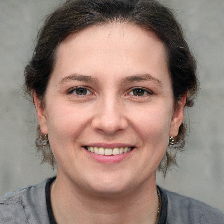

image 0/500 | loss: 0.7703208923339844


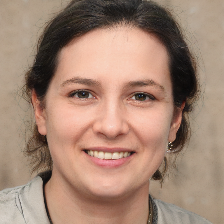

image 10/500 | loss: 0.7132110595703125


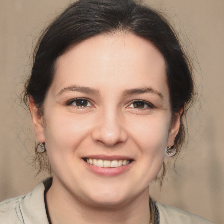

image 20/500 | loss: 0.676224946975708


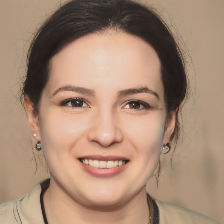

image 30/500 | loss: 0.6517794132232666


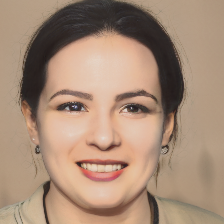

image 40/500 | loss: 0.6255401372909546


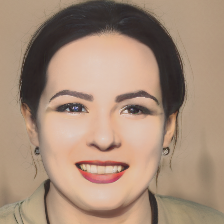

image 50/500 | loss: 0.6025571823120117


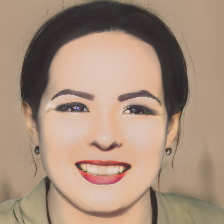

image 60/500 | loss: 0.581652820110321


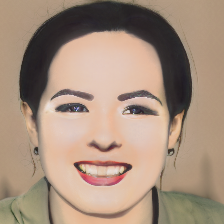

image 70/500 | loss: 0.5601180791854858


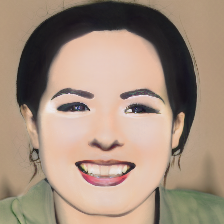

image 80/500 | loss: 0.5396775007247925


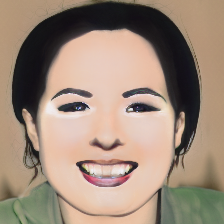

image 90/500 | loss: 0.5211669206619263


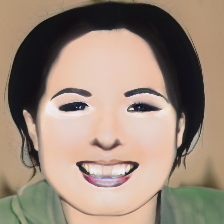

image 100/500 | loss: 0.5100588202476501


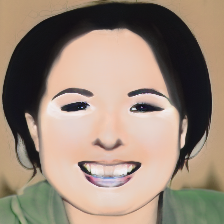

image 110/500 | loss: 0.4886769652366638


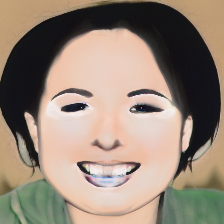

image 120/500 | loss: 0.4665960669517517


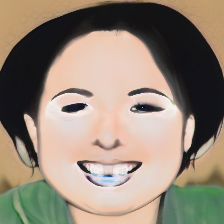

image 130/500 | loss: 0.4509522318840027


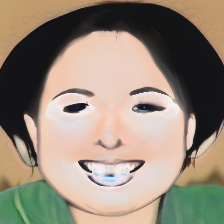

image 140/500 | loss: 0.42895078659057617


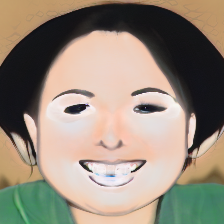

image 150/500 | loss: 0.41893211007118225


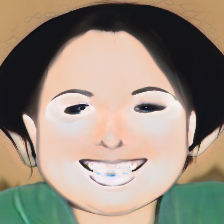

image 160/500 | loss: 0.4055686891078949


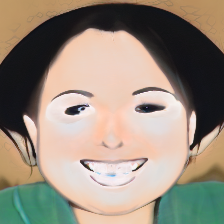

image 170/500 | loss: 0.3984840214252472


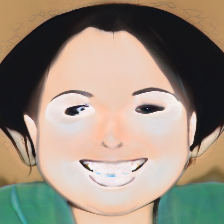

image 180/500 | loss: 0.38632842898368835


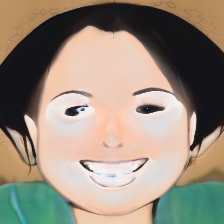

image 190/500 | loss: 0.3785201609134674


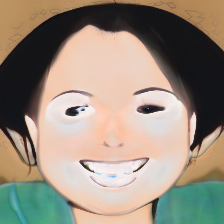

image 200/500 | loss: 0.37290066480636597


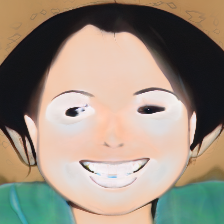

image 210/500 | loss: 0.3625067472457886


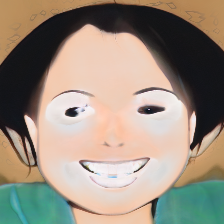

image 220/500 | loss: 0.35699620842933655


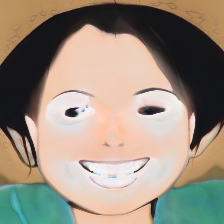

image 230/500 | loss: 0.35093584656715393


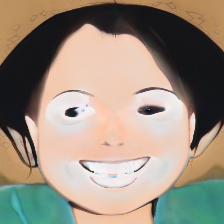

image 240/500 | loss: 0.3498183488845825


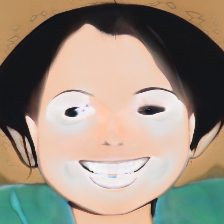

image 250/500 | loss: 0.3421150743961334


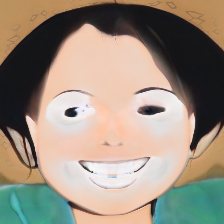

image 260/500 | loss: 0.3385021388530731


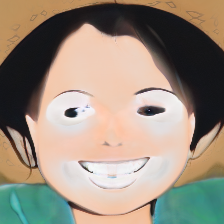

image 270/500 | loss: 0.3305223286151886


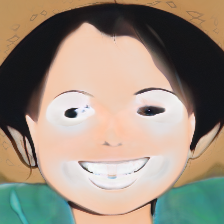

image 280/500 | loss: 0.3261481523513794


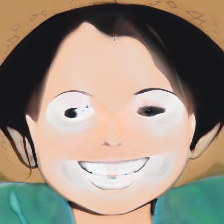

image 290/500 | loss: 0.32129141688346863


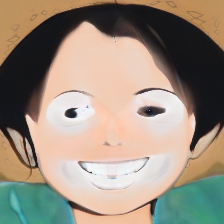

image 300/500 | loss: 0.3242271840572357


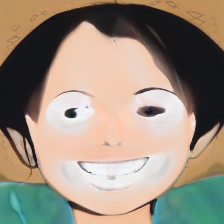

image 310/500 | loss: 0.321594774723053


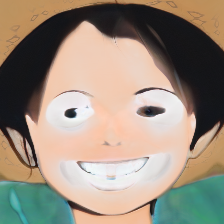

image 320/500 | loss: 0.3118327260017395


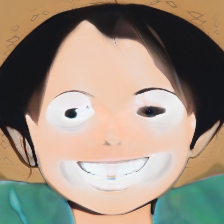

image 330/500 | loss: 0.30877766013145447


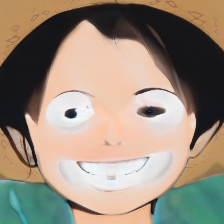

image 340/500 | loss: 0.30054330825805664


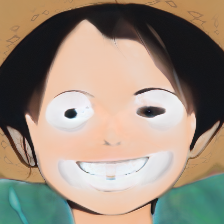

image 350/500 | loss: 0.29558876156806946


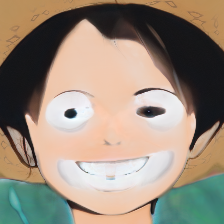

image 360/500 | loss: 0.29206180572509766


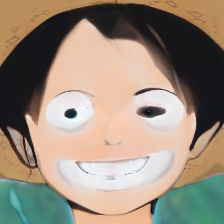

image 370/500 | loss: 0.29429498314857483


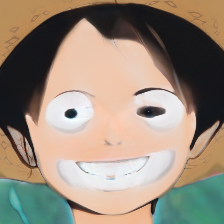

image 380/500 | loss: 0.28976619243621826


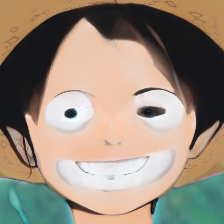

image 390/500 | loss: 0.28420671820640564


In [ ]:
#@markdown #**Run the inversion** 🚀

tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
])

seed = 14

def run(timestring, projection_target):
  torch.manual_seed(seed)

  target_features = get_target_features(projection_target)

  with torch.no_grad():
    w_avg_samples = 100
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)
    w_avg = torch.mean(w_samples, dim=0, keepdim=True)
    # qs = []
    # losses = []
    # for _ in range(1):
    #   q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
    #   images = G.synthesis(q * w_stds + G.mapping.w_avg)
    #   loss = get_perceptual_loss(images, target_features)
    #   i = torch.argmin(loss)
    #   qs.append(q[i])
    #   losses.append(loss)
    # qs = torch.stack(qs)
    # losses = torch.stack(losses)
    # i = torch.argmin(losses)
    # q = qs[i].unsqueeze(0).requires_grad_()
    q = w_avg.clone().detach().requires_grad_(True)

  # Sampling loop
  q_ema = q
  opt = torch.optim.AdamW([q], lr=0.03, betas=(0.9,0.999))
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis(w + G.mapping.w_avg, noise_mode='const')
    loss = get_perceptual_loss(image, target_features)
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * 0.9 + q * 0.1
    image = G.synthesis(q_ema * w_stds + G.mapping.w_avg, noise_mode='const')

    if i % 10 == 0:
      display(TF.to_pil_image(tf(image)[0]))
      print(f"image {i}/{steps} | loss: {loss}")
    pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
    os.makedirs(f'samples/{timestring}', exist_ok=True)
    pil_image.save(f'samples/{timestring}/{i:04}.jpg')

try:
  timestring = time.strftime('%Y%m%d%H%M%S')
  run(timestring, target_tensor)
except KeyboardInterrupt:
  pass

In [ ]:
#@markdown #**Generate video** 🎥

#@markdown You can edit frame rate and stuff by double-clicking this tab.

frames = os.listdir(f"samples/{timestring}")
frames = len(list(filter(lambda filename: filename.endswith(".jpg"), frames))) #Get number of jpg generated

init_frame = 1 #This is the frame where the video will start
last_frame = frames #You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.

min_fps = 10
max_fps = 60

total_frames = last_frame-init_frame

#Desired video time in seconds
video_length = 14 #@param {type:"number"}
#Video filename
video_name = "" #@param {type:"string"}
video_name = slugify(video_name)

if not video_name:
  video_name = "video"
# frames = []
# tqdm.write('Generating video...')
# for i in range(init_frame,last_frame): #
#     filename = f"samples/{timestring}/{i:04}.jpg"
#     frames.append(Image.open(filename))

fps = np.clip(total_frames/video_length,min_fps,max_fps)

print("Generating video...")
!ffmpeg -r {fps} -i samples/{timestring}/%04d.jpg -c:v libx264 -vf fps={fps} -pix_fmt yuv420p samples/{video_name}.mp4 -frames:v {total_frames}

# from subprocess import Popen, PIPE
# p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', f'samples/{video_name}.mp4'], stdin=PIPE)
# for im in tqdm(frames):
#     im.save(p.stdin, 'PNG')
# p.stdin.close()

print("The video is ready")

In [ ]:
#@markdown #**Download video** 📀

#Video filename

files.download(f"samples/{video_name}.mp4")